In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso
import numpy as np
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

In [2]:
sectors = pd.read_excel('49_Industry_Portfolios_Daily.xlsx', sheet_name='LSSector')
factors = pd.read_excel('49_Industry_Portfolios_Daily.xlsx', sheet_name='Factors')

In [3]:
stock_data = pd.read_csv('StockData.csv', header=None)

In [4]:
stock_dates = pd.read_csv('StockDates.csv', header=None)

In [5]:
print("Sector HEAD \n")
print(sectors.head())
print("Sector shape \n")
print(sectors.shape)
print("Sector describe \n")
print(sectors.describe)

print("Factor HEAD \n")
print(factors.head())
print("factors shape \n")
print(factors.shape)
print("factor describe \n")
print(factors.describe)

print("Sector HEAD \n")
print(stock_dates.head())
print("Sector HEAD \n")
print(stock_dates.shape)
print("Sector HEAD \n")
print(stock_dates.describe)

print(stock_data.head())
print(stock_data.shape)
print(stock_data.describe)

Sector HEAD 

        Row  Market_RF     Agric      Food      Soda      Beer     Smoke  \
0  19900102       1.44  0.384446 -1.528202 -1.245530 -0.458392  1.087373   
1  19900103      -0.06 -0.816019 -0.637575 -0.436020 -0.537150  1.133026   
2  19900104      -0.71  1.233780 -0.164637  0.783768 -0.039612 -2.487524   
3  19900105      -0.85  0.613737  0.021689  1.553723 -0.112296  1.200203   
4  19900108       0.30 -0.175907 -0.388125  0.404098  0.949752 -2.911131   

       Toys       Fun     Books  ...     Boxes     Trans     Whlsl     Rtail  \
0  0.228338  0.425476  0.001780  ...  0.260234  0.770604 -0.102255  1.429006   
1 -0.796181  0.353105 -0.927158  ...  0.383740 -0.677109 -0.456573  0.650458   
2  0.071861  0.633411  0.730303  ...  0.320926  0.300883 -0.062777  0.552087   
3  0.681439  0.771323 -0.202398  ...  0.500320  0.098296  0.375887  0.293823   
4 -0.505096 -0.251526 -0.210212  ...  0.585299 -0.080457 -0.353136 -0.128290   

      Meals     Banks     Insur     RlEst       

In [6]:
sum_column = stock_dates[stock_dates.columns[0]].astype(str).copy()
for column in stock_dates.columns[1:]:
    sum_column += stock_dates[column].astype(str) if stock_dates[column].astype(str)[0] != '.' else ''

In [7]:
sum_column = pd.to_datetime(sum_column, format='%d%m%Y')

In [8]:
stock_data['date'] = sum_column
del sum_column
del stock_dates
stock_data['date'].head()

0   1990-01-03
1   1990-01-04
2   1990-01-05
3   1990-01-06
4   1990-01-09
Name: date, dtype: datetime64[ns]

In [9]:
factors['Unnamed: 0'] = pd.to_datetime(factors['Unnamed: 0'], format='%Y%m%d')

In [10]:
sectors['Row'] = pd.to_datetime(sectors['Row'], format='%Y%m%d')


In [46]:
import statsmodels.api as sm
import statsmodels
def _prepare_X_y(stock_data, predictor_frame, index, predictor_on='Row'):
    stock_1_data = stock_data[['date', index]]

    stock_1_sectors = pd.merge(predictor_frame, stock_1_data,left_on=predictor_on, right_on='date')
    columns = list(stock_1_sectors.columns).copy()
    columns[-1] = 'stock_price'
    stock_1_sectors.columns = columns
    stock_1_sectors = stock_1_sectors.sort_values(by=[predictor_on])
    if 'Market_RF' in stock_1_sectors.columns:
        stock_1_sectors.drop(labels=['Market_RF'], axis=1, inplace=True)
    elif 'Mkt-RF' in stock_1_sectors.columns:
        stock_1_sectors.drop(labels=['Mkt-RF', 'RF'], axis=1, inplace=True)
    stock_1_sectors.drop(labels=['date'], axis=1, inplace=True)
    daily_stock_returns = stock_1_sectors['stock_price'].copy().pct_change()


    X = stock_1_sectors[stock_1_sectors.columns.difference(['stock_price', predictor_on])]
    dates = stock_1_sectors[predictor_on].copy()
    y = daily_stock_returns
    return X, y, dates


# def plot_model(beta, regressor, regressor_name, model, stock, title):
#     #Plot data and regression lines
#     fig = plt.figure(figsize=(18,6))
#     fig.suptitle(title, fontsize=22)
#     ax1 = fig.add_subplot(121)
#     ax1.scatter(regressor, stock, color='blue', alpha=0.3)
#     print(regressor)
#     ax1.plot(regressor, model.predict(regressor), color='red', linewidth=2, label=f"{regressor_name}")
#     ax1.set_title(f"High Beta: {beta}", {'fontsize': 16})
#     ax1.set_ylabel('Percent Return of Individual Securities', {'fontsize': 16})
#     ax1.set_xlabel('Percent Return of the S&P 500 Index', {'fontsize': 16}, labelpad=10)
#     ax1.set_xlim(-0.1, 0.1)
#     ax1.set_ylim(-0.5, 0.5)
#     ax1.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
#     ax1.grid(True, which='both')
#     ax1.axhline(y=0, color='black', linestyle=':')
#     ax1.axvline(x=0, color='black', linestyle=':')
#     ax1.legend(loc='upper right', fontsize='large')
#     extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     fig.savefig(f'plots/line_fit_{regressor_name}_stock.png', bbox_inches=extent.expanded(1.1, 1.2))


def get_alpha_beta_mse(X, y, dates, training_length):
    alphas = []
    betas = []
    mse = []
    r2_scores = []
    for row_break in range(0, y.shape[0], training_length):
        X_train, y_train = X.iloc[row_break: row_break + training_length].copy(), \
                           y.iloc[row_break: row_break + training_length].copy()
        y_train = y_train.interpolate()
        y_train = y_train.fillna(method='bfill')
        y_train =  y_train[y_train.index.isin(X_train.index)]
        if all(y_train.isna()):
            # print("Skipping stock data for ", row_break)
            continue
        X_train = sm.add_constant(X_train)
        regression_model = sm.OLS(y_train * 100, X_train)
        regression_results = regression_model.fit()
        alphas.append(round(float(regression_results.params.const), 5))
        betas.append([round(float(regression_results.params.tolist()[i]), 5)
                      for i, param in enumerate(regression_results.params.index) if param != 'const'])
        # betas.append([round(float(coef), 5) for coef in regression_model.coef_])
        r2_scores.append(regression_results.rsquared)
        mse.append(regression_results.mse_total)
        # regression_model = LinearRegression()
        # regression_model.fit(X_train.to_numpy(), y_train.to_numpy() -1)
        # alphas.append(round(float(regression_model.intercept_), 5))
        # betas.append([round(float(coef), 5) for coef in regression_model.coef_])
        # mse.append(regression_model.score(X_train.to_numpy(), y_train))
        # r2_scores.append(r2_score(y_train.to_numpy(), regression_model.predict(X_train.to_numpy())))

        # if row_break == 0:
        #     regressor_name = list(X_train.columns)[0]
        #     plot_model(beta=betas[0], regressor=X_train[regressor_name],
        #                regressor_name=regressor_name,
        #                model=regression_model,
        #                stock=y_train,
        #                title=f"Predicted monthly stock returns based on {regressor_name} from {dates[row_break]}"
        #                      f" to {dates[row_break+training_length]}, training Mean Square Error:: {mse[0]}")
    betas = pd.DataFrame(betas, columns=X.columns)
    return alphas, betas, mse, r2_scores

def perform_significance_test(alpha_1=None, alpha_2=None, betas_1=None, betas_2=None):
    significance = dict()
    if alpha_1 is not None and alpha_2 is not None:
        significance['alpha'] = dict()
        significance['alpha']['less'] = wilcoxon(alpha_1, alpha_2, alternative='less')
        significance['alpha']['two-sided'] = wilcoxon(alpha_1, alpha_2, alternative='two-sided')
    elif betas_2 is not None and betas_1 is not None:
        significance['betas'] = dict()
        significance['betas']['two-sided'] = wilcoxon(betas_1, betas_2, alternative='two-sided')
        significance['betas']['less'] = wilcoxon(betas_1, betas_2, alternative='less')
    else:
        raise ValueError('missing arguments to function')
    return significance

def run_experiment_single_training_length(regressor, regressor_on, training_length, stocks):
    results = list()
    for column in stocks.columns[:300]:
        if column == 'date':
            continue
        results.append(dict())
        if column % 10 == 0:
            print("Running on", column)
        X, y, dates = _prepare_X_y(stocks, regressor, column, predictor_on=regressor_on)
        if any(y.isna()):
            counts = y.isna().value_counts(normalize=True)
            if False in counts and counts[False] < 0.75:
                print('skipping stock', column)
                continue
            elif False not in counts:
                print('skipping stock', column)
                continue
        alphas, betas, mse, r2_scores = get_alpha_beta_mse(X, y, dates, training_length)
        # print(betas)
        results[column]['alpha'] = np.mean(alphas)
        results[column]['betas'] = betas.mean(axis=0)
        results[column]['mse'] = np.mean(mse)
        results[column]['r2_scores'] = np.mean(r2_scores)

    return results

# def run_experiment_two_training_length_single_stock(regressor,
#                                                      regressor_on,
#                                                      training_length_1,
#                                                      training_length_2,
#                                                      stocks):
#     results_1 = run_experiment_single_training_length(regressor,
#                                                       regressor_on,
#                                                       training_length_1,
#                                                       stocks)
#     results_2 = run_experiment_single_training_length(regressor,
#                                                       regressor_on,
#                                                       training_length_2,
#                                                       stocks)
#     return results_1, results_2

In [47]:

training_lengths = np.linspace(100, 250, num=4, dtype=int)

In [48]:
results = dict()
for training_length in training_lengths:
    if training_length not in results:
        results[training_length] = run_experiment_single_training_length(factors,
                                                                         'Unnamed: 0',
                                                                         training_length=training_length,
                                                                         stocks=stock_data.copy())

Running on 0


/home/ravin/anaconda3/envs/economics_analysis/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


skipping stock 4
skipping stock 7
Running on 10
skipping stock 13
skipping stock 16
skipping stock 17
skipping stock 18
Running on 20
skipping stock 26
Running on 30
skipping stock 34
Running on 40
skipping stock 41
skipping stock 46
Running on 50
skipping stock 50
skipping stock 56
Running on 60
skipping stock 62
skipping stock 67
skipping stock 68
Running on 70
skipping stock 71
skipping stock 72
skipping stock 74
Running on 80
skipping stock 81
skipping stock 84
skipping stock 87
Running on 90
skipping stock 97
skipping stock 98
skipping stock 99
Running on 100
Running on 110
skipping stock 115
skipping stock 116
Running on 120
skipping stock 122
skipping stock 123
skipping stock 124
Running on 130
skipping stock 130
skipping stock 131
skipping stock 137
Running on 140
skipping stock 147
Running on 150
skipping stock 157
skipping stock 159
Running on 160
skipping stock 164
Running on 170
skipping stock 172
Running on 180
skipping stock 181
skipping stock 183
skipping stock 185
skipp

In [49]:
import itertools

pairs = itertools.permutations(training_lengths, 2)

significance_alpha = dict()
for pair in pairs:
    if pair not in significance_alpha:
        results_1 = results[pair[0]]
        results_2 = results[pair[1]]
        significance_alpha[pair] = perform_significance_test(alpha_1=[result['alpha'] for result in results_1 if 'alpha' in result],
                                                             alpha_2=[result['alpha'] for result in results_2 if 'alpha' in result])

In [50]:
beta_results = dict()

for key, item in results.items():
    if key not in beta_results:
        beta_results[key] = dict()
        for i, stock in enumerate(item):
            if 'betas' not in stock:
                continue
            for factor_beta_column in stock['betas'].index:
                if factor_beta_column not in beta_results[key]:
                    beta_results[key][factor_beta_column] = dict()
                beta_results[key][factor_beta_column][i] = stock['betas'][factor_beta_column]

In [51]:
factors_names = list(factors.columns.difference(['Unnamed: 0', 'Mkt-RF', 'RF'])).copy()

pairs = itertools.permutations(training_lengths, 2)

significance_beta = dict()
for pair in pairs:
    if pair not in significance_beta:
        significance_beta[pair] = dict()
    for factor_name in factors_names:
        if factor_name not in significance_beta[pair]:
            betas_1 = list(beta_results[pair[0]][factor_name].values())
            betas_2 = list(beta_results[pair[1]][factor_name].values())
            significance_beta[pair][factor_name] = perform_significance_test(betas_1=betas_1,
                                                                             betas_2=betas_2)

In [17]:
for pair in pairs:
    print(pair)

(100, 200)
(100, 250)
(150, 100)
(150, 200)
(150, 250)
(200, 100)
(200, 150)
(200, 250)
(250, 100)
(250, 150)
(250, 200)


In [ ]:
print(stock_data.shape)

In [ ]:
factors_names

In [72]:
import matplotlib
from sklearn.metrics import r2_score

font = {'family' : 'normal',
        'size'   : 12}
matplotlib.rc('axes', titlesize=40)
matplotlib.rc('font', **font)
X, y, dates = _prepare_X_y(stock_data.copy(), factors, 0, predictor_on='Unnamed: 0')
def plot_model(alpha, beta, regressor, regressor_name, model, stock, title):
    #Plot data and regression lines
    fig = plt.figure(figsize=(27,12))
    # fig.suptitle(title, fontsize=22)
    print(title)
    ax1 = fig.add_subplot(121)
    ax1.scatter(regressor[:, 1], stock, color='blue', alpha=0.3)
    r2 = model[1].rsquared
    print(regressor[:, 1].shape)
    ax1.plot(regressor[:, 1], model[0].predict(regressor), color='red', linewidth=2, label=f"{regressor_name}")
    ax1.set_title(f" Alpha: {round(alpha, 3)} Beta: {round(beta, 3)} R2: {round(r2, 3)}", {'fontsize': 16})
    ax1.set_ylabel('Percent Return of Stock', {'fontsize': 16})
    ax1.set_xlabel('Return of CMA', {'fontsize': 16}, labelpad=10)
    # ax1.set_xlim(-0.1, 0.1)
    # ax1.set_ylim(-0.5, 0.5)
    # ax1.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax1.grid(True, which='both')
    ax1.axhline(y=0, color='black', linestyle=':')
    ax1.axvline(x=0, color='black', linestyle=':')
    ax1.legend(loc='upper right', fontsize='large')
    plt.savefig(f'plots/line_fit_{regressor_name}_stock.png')

In [73]:
X = X['CMA'].iloc[100:400].to_numpy().reshape(-1, 1)
y = y.iloc[100:400].interpolate().fillna(method='bfill').to_numpy() * 100

from sklearn.linear_model import LinearRegression

X = sm.add_constant(X)
model = sm.OLS(y, X)

results_one = model.fit()


Monthly Performance from 03/07/1990 to 14/01/1992 for CMA on Stock 0
(300,)


ValueError: shapes (300,2) and (300,2) not aligned: 2 (dim 1) != 300 (dim 0)

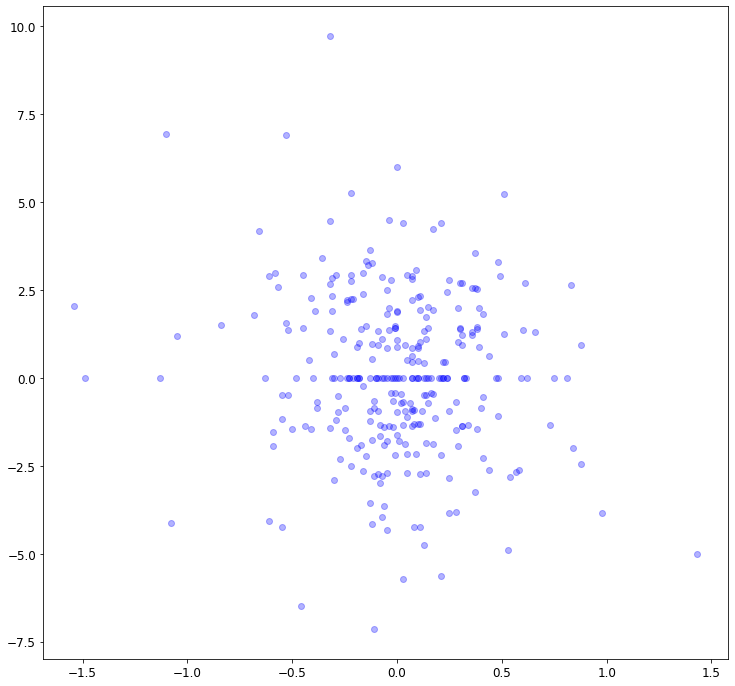

In [74]:
print()
plot_model(alpha=results_one.params[0], beta=results_one.params[-1], regressor=X, regressor_name='CMA', model=(model, results_one), stock=y, title=f"Monthly Performance from {dates[100].strftime('%d/%m/%Y')} to {dates[399].strftime('%d/%m/%Y')} for CMA on Stock 0")

In [173]:
model.score(X, y)

0.014791417020967979

In [59]:

for key, item in significance_beta.items():
    print(key)
    print(item['HML']['betas']['less'].pvalue)

(100, 150)
0.03801534066423943
(100, 200)
0.6745097184680902
(100, 250)
0.000521027007852256
(150, 100)
0.9619846593357606
(150, 200)
0.9926165267388447
(150, 250)
0.0005964680924183128
(200, 100)
0.3254902815319099
(200, 150)
0.0073834732611553384
(200, 250)
6.659610133139668e-08
(250, 100)
0.9994789729921477
(250, 150)
0.9994035319075817
(250, 200)
0.9999999334038987


In [60]:

for key, item in significance_beta.items():
    print(key)
    print(item['HML']['betas']['two-sided'].pvalue)

(100, 150)
0.07603068132847886
(100, 200)
0.6509805630638198
(100, 250)
0.001042054015704512
(150, 100)
0.07603068132847886
(150, 200)
0.014766946522310677
(150, 250)
0.0011929361848366255
(200, 100)
0.6509805630638198
(200, 150)
0.014766946522310677
(200, 250)
1.3319220266279337e-07
(250, 100)
0.001042054015704512
(250, 150)
0.0011929361848366255
(250, 200)
1.3319220266279337e-07


In [61]:
for key, item in significance_alpha.items():
    print(key)
    print(item['alpha']['less'].pvalue)

(100, 150)
3.3389634702971013e-07
(100, 200)
2.078138525915489e-10
(100, 250)
2.721776918783708e-10
(150, 100)
0.999999666103653
(150, 200)
0.2425041242104402
(150, 250)
0.06928735938981347
(200, 100)
0.9999999997921861
(200, 150)
0.7574958757895598
(200, 250)
0.00636647084330056
(250, 100)
0.9999999997278223
(250, 150)
0.9307126406101865
(250, 200)
0.9936335291566994


In [62]:
for key, item in significance_alpha.items():
    print(key)
    print(item['alpha']['two-sided'].pvalue)

(100, 150)
6.677926940594203e-07
(100, 200)
4.156277051830978e-10
(100, 250)
5.443553837567416e-10
(150, 100)
6.677926940594203e-07
(150, 200)
0.4850082484208804
(150, 250)
0.13857471877962693
(200, 100)
4.156277051830978e-10
(200, 150)
0.4850082484208804
(200, 250)
0.01273294168660112
(250, 100)
5.443553837567416e-10
(250, 150)
0.13857471877962693
(250, 200)
0.01273294168660112
